In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split

import tensorflow as tf

import os
import pickle
import numpy as np

print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Using TensorFlow backend.


Tensorflow version: 1.1.0
Keras version: 2.0.8


In [2]:
batch_size = 32
img_height, img_width = 256, 256

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(img_height, img_width),
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(img_height, img_width),
        batch_size=batch_size)

Found 41539 images belonging to 132 classes.
Found 7331 images belonging to 132 classes.


In [13]:
num_epochs = 10
num_classes = 132

In [14]:
# create the base pre-trained model
base_model = InceptionV3(input_tensor=Input(shape=(256, 256, 3)), weights='imagenet', include_top=False)

In [15]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    workers=4)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    workers=4)

Epoch 1/10
1298/1298 [==============================] - 460s - loss: 3.3057 - acc: 0.2453 - val_loss: 2.3824 - val_acc: 0.4084
Epoch 2/10
1298/1298 [==============================] - 456s - loss: 2.4300 - acc: 0.3936 - val_loss: 2.3366 - val_acc: 0.4204
Epoch 3/10
1298/1298 [==============================] - 457s - loss: 2.2742 - acc: 0.4300 - val_loss: 2.3050 - val_acc: 0.4308
Epoch 4/10
1298/1298 [==============================] - 453s - loss: 2.2159 - acc: 0.4462 - val_loss: 2.2133 - val_acc: 0.4636
Epoch 5/10
1298/1298 [==============================] - 459s - loss: 2.1807 - acc: 0.4603 - val_loss: 2.2021 - val_acc: 0.4645
Epoch 6/10
1298/1298 [==============================] - 467s - loss: 2.1729 - acc: 0.4640 - val_loss: 2.2596 - val_acc: 0.4604
Epoch 7/10
1298/1298 [==============================] - 463s - loss: 2.1661 - acc: 0.4634 - val_loss: 2.2702 - val_acc: 0.4471
Epoch 8/10
1298/1298 [==============================] - 463s - loss: 2.1694 - acc: 0.4661 - val_loss: 2.3369 - 

1298/1298 [==============================] - 480s - loss: 1.2427 - acc: 0.6590 - val_loss: 1.5191 - val_acc: 0.6092
Epoch 7/10
1298/1298 [==============================] - 479s - loss: 1.1792 - acc: 0.6743 - val_loss: 1.4928 - val_acc: 0.6175
Epoch 8/10
1298/1298 [==============================] - 481s - loss: 1.1325 - acc: 0.6835 - val_loss: 1.4687 - val_acc: 0.6223
Epoch 9/10
1298/1298 [==============================] - 481s - loss: 1.0899 - acc: 0.6939 - val_loss: 1.4606 - val_acc: 0.6281
Epoch 10/10
1298/1298 [==============================] - 481s - loss: 1.0571 - acc: 0.7026 - val_loss: 1.4414 - val_acc: 0.6341


In [ ]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(test_generator,
                                      steps=test_generator.samples // batch_size,
                                      workers=4)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

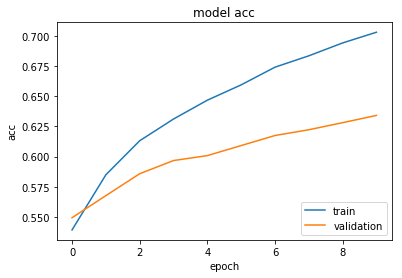

In [16]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(history)